In [7]:
from tika import parser
import os
from os import listdir
from os.path import isfile, join
import re
from collections import defaultdict
import time
from datetime import date, timedelta
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

In [36]:
# hard-coded values
# path of morningstar recommendations, pdfs
path = "process-pdf/"
# ticker of standard&poor's
SNP = {'^GSPC': 0}

#v alues from user input
# day is input from drop box
day = "2018-02-23"
# traillngTime is input from check box
traillngTime = 30
# trading quantity: threeStarVolume, fourStarVolume, fiveStarVolume
threeStarVolume = 0
fourStarVolume = 0
fiveStarVolume = 900

#processed data
day = ''.join(day.split('-'))
report_date = date(int(day[0:4]),int(day[4:6]),int(day[6:8]))
end_date = report_date+timedelta(days=traillngTime)
shares = {0: 100, 3: threeStarVolume, 4: fourStarVolume, 5: fiveStarVolume}

In [37]:
def retriveFiles(path):
    return [join(path, f) for f in listdir(path) if isfile(join(path, f)) and 'DS_store' not in f]

In [38]:
files = retriveFiles(path)

In [39]:
# from PyPDF2 import PdfFileReader, PdfFileWriter
 
# def pdf_splitter(path, name):
#     fname = os.path.splitext(os.path.basename(path))[0]
 
#     pdf = PdfFileReader(path)
#     pdf_writer = PdfFileWriter()
#     for page in range(pdf.getNumPages()):
#         if page != 0:
#             if "Best Ideas" in pdf.getPage(page).extractText():
#                 pdf_writer.addPage(pdf.getPage(page))
#     output_filename = '{}.pdf'.format(name)
#     with open(output_filename, 'wb') as out:
#         pdf_writer.write(out)

In [40]:
def generateDates(files):
    root = len(path)
    res = []
    for file in files:    
        dstr = file[root:root+8]
        d = date(int(dstr[0:4]),int(dstr[4:6]),int(dstr[6:8])).strftime("%Y-%m-%d")
        res.append(d)
#         pdf_splitter(file, dstr)
    return res

In [35]:
days = generateDates(files)

In [8]:
def retrieveRatings(files, day):
    for file in files:
        if day in file:
            break
    raw = parser.from_file(file)
    pattern = '\(.+\) Q+'
    data_pairs = re.findall(pattern, raw['content'])
    res = defaultdict(int)
    for data in data_pairs:
        pair = data.split(' ');
        res[pair[0][1:-1]] = len(pair[1])
        
    return res

In [9]:
ticker_rating_pair = retrieveRatings(files, day)

In [10]:
# # Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# tickers = ['0700', 'MSFT', '^GSPC']

# # We would like all available data from 01/01/2000 until 12/31/2016.
# report_date = datetime(2018, 3, 7)
# end_date = datetime(2018, 3, 15)

# # User pandas_reader.data.DataReader to load the desired data. As simple as that.
# panel_data = data.DataReader('MSFT', 'yahoo', report_date, end_date)

# for ticker in tickers:
#     try:    
#         print(ticker, data.DataReader(ticker, 'yahoo', report_date, end_date).iloc[0]['Close'], sep = ": $")
#     except:
#         print(ticker, " is not public traded in North America stock market, ignored...", sep = "")

In [11]:
# [pd.to_datetime(d).strftime("%m/%d/%Y") for d in list(panel_data.index.values)]

In [24]:
#get open and close prices from yahoo api
#return dic {ticker: [rating, [price1, price2, ...]], ...}
def getTickerPrices(report_date, end_date, ticker_rating_pair):
    res = defaultdict(list)
    for ticker, rating in ticker_rating_pair.items():
        try:    
            price_info = data.DataReader(ticker, 'yahoo', report_date, end_date)
            prices = []
            for i in range (price_info.shape[0]):
                prices.append(price_info.iloc[i]['Close'])
            res[ticker] = [rating, prices]
        except:
            print(ticker, " is not public traded in North America stock market, ignored...", sep = "")
    return res

In [25]:
ticker_prices = getTickerPrices(report_date, end_date, ticker_rating_pair)
snp_prices = getTickerPrices(report_date, end_date, SNP)

ESRX is not public traded in North America stock market, ignored...
HSO is not public traded in North America stock market, ignored...
RHC is not public traded in North America stock market, ignored...
SHP is not public traded in North America stock market, ignored...
392 is not public traded in North America stock market, ignored...
BXB is not public traded in North America stock market, ignored...
1 is not public traded in North America stock market, ignored...
GFS is not public traded in North America stock market, ignored...
G1A is not public traded in North America stock market, ignored...
525 is not public traded in North America stock market, ignored...
KGX is not public traded in North America stock market, ignored...
PHIA is not public traded in North America stock market, ignored...
AOG is not public traded in North America stock market, ignored...
6762 is not public traded in North America stock market, ignored...
700 is not public traded in North America stock market, ignor

In [14]:
#calculate daily profits
#return list [profit1, profit2]
#prices: dict {ticker: [rating, [price1, price2, ...]], ...}
#shares: dict {3: quantity, 4: quantity, 5: quantity}

def calculateProfits(ticker_prices, shares):
    balance  = [0] * len(next(iter(ticker_prices.values()))[1])
    
    for ticker, ops in ticker_prices.items():
        rating = ops[0]
        prices = ops[1]
        for i in range(len(balance)):
            balance[i] = balance[i] + prices[i]*shares[rating]
    profits_percentage = [0] * len(balance)
    for i in range(len(balance)):
        profits_percentage[i] = (balance[i]-balance[0])/balance[0]
    return profits_percentage

In [15]:
profits = calculateProfits(ticker_prices, shares)

profits_snp = calculateProfits(snp_prices, shares)

In [16]:
def getDealDays(report_date, end_date, ticker):
    panel_data = data.DataReader(ticker, 'yahoo', report_date, end_date)
    return [pd.to_datetime(d).strftime("%y/%m/%d") for d in list(panel_data.index.values)]

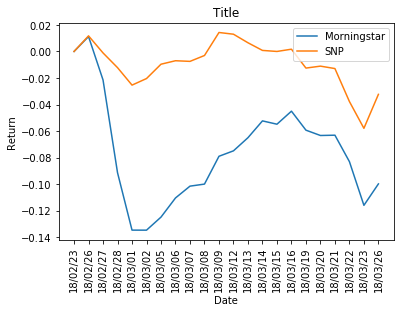

In [17]:
deal_days =  getDealDays(report_date, end_date, '^GSPC')
l1, = plt.plot(deal_days,profits, label='Morningstar')
l2, = plt.plot(deal_days,profits_snp, label='SNP')
plt.legend(loc='upper right')
plt.title('Title')
plt.xlabel('Date')
plt.ylabel('Return')
plt.xticks(rotation=90)
plt.show()

In [18]:
def getFormatedTickerPrice(ticker_prices, shares):
    s = "Ticker Quantity Open_Price Close_Price\n"
    for ticker, ops in ticker_prices.items():
        ticker = "{:<6}".format(ticker)
        rating = ops[0]
        rating = "{:<8}".format(str(shares[rating]))
        s = s + ticker + ' ' + rating
        prices = ops[1]
        open_price = "{:<10}".format( str(round(prices[0],2)) )
        close_price = "{:11}".format( str(round(prices[-1],2)) )
        s = s + ' '+  open_price +' '+ close_price
        s = s+'\n'
    return s

In [19]:
print(getFormatedTickerPrice(ticker_prices, shares))

Ticker Quantity Open_Price Close_Price
AGN    900      162.09     160.2      
MCK    0        152.65     139.29     
ROG    900      160.53     126.67     
AXE    0        78.15      75.15      
FLR    0        58.15      56.32      
JCI    0        38.82      34.94      
SRCL   0        60.05      58.84      
VNO    0        67.67      65.16      
GWRE   0        81.18      83.29      
KLAC   0        110.47     113.36     
MYO    0        3.92       3.25       
QCOM   0        63.32      56.13      
SABR   0        23.81      21.88      
CRM    0        114.96     118.97     
SYNA   0        46.59      47.09      
D      0        75.52      68.1       
FE     900      33.8       33.99      

